# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 3. Детекция объектов. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### Консультация 2023 года

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# !curl -LO https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
# !python -m zipfile -e data.zip .

In [2]:
import shutil
from pathlib import Path
from xml.etree import ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from matplotlib.patches import Rectangle

import cv2
# from PIL import Image

from torch import nn
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="xmls"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = Path(image_name).stem
    # read xml
    xml_path = root / xml_prefix / f"{filename}.xml"
    tree = ET.parse(xml_path)
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.

        bbox = member.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        xmax = int(bbox.find("xmax").text)
        ymin = int(bbox.find("ymin").text)
        ymax = int(bbox.find("ymax").text)
        
        class_id = class_dict.get(member.find("name").text)

        res = [xmin, ymin, xmax, ymax, class_id]
        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(list((self.root / "images").glob("*")))
        with open(self.root / "class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = cv2.imread(str(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict)
        
        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images: list[torch.Tensor], bboxes):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        image = images[i] * std + mean
        image = torch.clip(image, 0, 1)
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Вот тут покажите картинку после отката нормализации
        ax.imshow(image_np)

        for bbox in bboxes[i]:
            # Вот тут нарисуйте бибоксы
            # [xmin, ymin, xmax, ymax, class]
            x0 = bbox[0]
            y0 = bbox[1]
            w = bbox[2] - x0
            h = bbox[3] - y0

            rect = Rectangle(
                xy=(x0, y0),
                width=w,
                height=h,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            
            class_name = train_ds.class_dict_inv[int(bbox[4])]
            ax.text(
                x0, y0,
                class_name,
                color='white',
                bbox=dict(facecolor='red', alpha=0.5)
            )

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

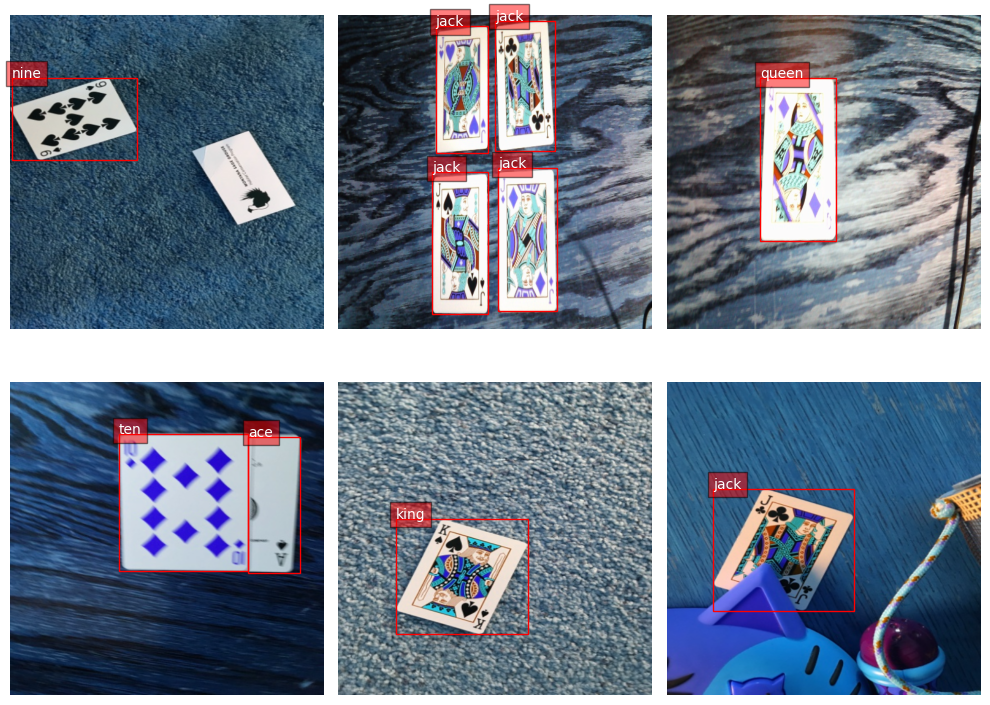

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код. 

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = (w / (w // downsample))
        y_cell = (h / (h // downsample))
        
        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box = (xmax - xmin) / w
        h_box = (ymax - ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        
        cx_idx = (cx // x_cell).long()
        cy_idx = (cy // y_cell).long()

        cx_box = (cx % x_cell) / x_cell
        cy_box = (cy % y_cell) / y_cell

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [10]:
def test_collate_fn() -> None:
    target1 = [100, 200, 200, 300, 2]  # xmin, ymin, xmax, ymax, class
    target2_1 = [0, 250, 200, 300, 0]  # xmin, ymin, xmax, ymax, class
    target2_2 = [0, 100, 100, 300, 1]  # xmin, ymin, xmax, ymax, class

    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": [target1]},
            {"image": torch.rand((3, 512, 512)), "bboxes": [target2_1, target2_2]},
        ]
    )

    # Проверяем размерности
    assert result["image"].shape == (2, 3, 512, 512)
    assert result["target"].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(
        result["target"][0, :, 7, 4],
        torch.tensor([22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2]),
    )
    assert np.allclose(
        result["target"][1, :, 8, 3],
        torch.tensor([4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0]),
    )
    assert np.allclose(
        result["target"][1, :, 6, 1],
        torch.tensor([18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1]),
    )

    # Проверяем, что все остальные клеточки содержат нули
    result["target"][0, :, 7, 4] = result["target"][1, :, 8, 3] = result["target"][
        1, :, 6, 1
    ] = torch.zeros(6)
    assert np.allclose(result["target"], 0)


test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

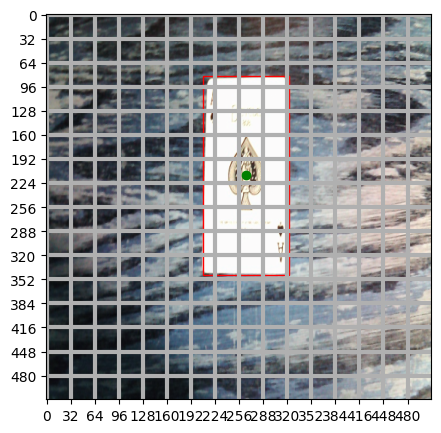

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему? 

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами. 

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [12]:
from typing import List

def decode_prediction(pred: torch.Tensor, upsample=32, threshold=0.7) -> List[List[List[float]]]:
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    result = []
    # 3 for: one for batch
    # two for x and y coord of the grid (hyperpixels)
    # result[0] == bboxes on image 0
    # result[0][0] == first bbox on image 0
    # result[0][0] == [xmin, ymin, xmax, ymax, class]

    x_cell = img_w / w
    y_cell = img_h / h
    
    for i in range(b):
        boxes = []
        
        confidence = pred[i, 4, :, :]
        valids = torch.nonzero(confidence >= threshold, as_tuple=True)
        
        if len(valids[0]) > 0:
            for y_idx, x_idx in zip(*valids):
                cell = pred[i, :, y_idx, x_idx]
                cx_box, cy_box, w_box, h_box = [val.item() for val in cell[:4]]
                
                if c == 6:  # таргет
                    class_id = cell[5].item()
                else:       # выход нейронки
                    class_id = torch.argmax(cell[5:]).item()
                
                cx = (x_idx + cx_box) * x_cell
                cy = (y_idx + cy_box) * y_cell
                
                box_width = w_box * img_w
                box_height = h_box * img_h
                
                xmin = cx - box_width / 2
                ymin = cy - box_height / 2
                xmax = cx + box_width / 2
                ymax = cy + box_height / 2
                
                boxes.append([xmin, ymin, xmax, ymax, class_id])
        
        result.append(boxes)
    
    return result

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [13]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [[100, 200, 200, 300, 2]]
    target2 = [[0, 250, 200, 300, 0], [0, 100, 100, 300, 1]]
    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": target1},
            {"image": torch.rand((3, 512, 512)), "bboxes": target2},
        ]
    )

    target = result["target"]
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat(
        [target, torch.zeros(2, 2, 16, 16)], dim=1
    )  # Добавляем два канала
    assert target.shape == (2, 8, 16, 16)  # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([0.5, 0.6, 0.9])  # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([0.9, 0.6, 0.5])  # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([0.6, 0.9, 0.5])  # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print("Actual:  ", actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [target1, [target2[1], target2[0]]]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print("Expected:", expected)

    # Сравниваем
    assert actual == expected


test_decode_predictions()

Actual:   [[[tensor(100.), tensor(200.), tensor(200.), tensor(300.), 2]], [[tensor(0.), tensor(100.), tensor(100.), tensor(300.), 1], [tensor(0.), tensor(250.), tensor(200.), tensor(300.), 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно, можно при помощи ```list(model.children())[:-2]```) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [14]:
C = len(train_ds.class_dict)

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(model.children())[:5]) # выход [B, C, H, W] = [b, 256, 512/4, 512/4]

        self.tail = nn.Sequential(
            # C: 256->128, WxH: 128x128->64x64
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # C: 128->64, WxH: 64x64->32x32
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # C: 64->32, WxH: 32x32->16x16
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # C: 32->C+5, WxH: 16x16
            nn.Conv2d(32, C+5, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        resnet_result = self.resnet(img)
        tail_result = self.tail(resnet_result)

        return tail_result

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [15]:
def special_loss(pred, target, C=20):
    obj_mask = target[:, 4, :, :] == 1  # [B, 16, 16]
    noobj_mask = ~obj_mask

    # Localization loss
    pred_loc = pred[:, 0:2, :, :].masked_select(obj_mask.unsqueeze(1)).view(-1, 2)
    target_loc = target[:, 0:2, :, :].masked_select(obj_mask.unsqueeze(1)).view(-1, 2)
    localization_loss = F.mse_loss(pred_loc, target_loc, reduction='sum')

    # Box loss
    pred_box = pred[:, 2:4, :, :].masked_select(obj_mask.unsqueeze(1)).view(-1, 2)
    target_box = target[:, 2:4, :, :].masked_select(obj_mask.unsqueeze(1)).view(-1, 2)
    pred_box = torch.sqrt(torch.clamp(pred_box, min=1e-6))
    target_box = torch.sqrt(torch.clamp(target_box, min=1e-6))
    box_loss = F.mse_loss(pred_box, target_box, reduction='sum')

    # Classification loss
    pred_class = pred[:, 5, :, :].masked_select(obj_mask)
    target_class = target[:, 5, :, :].masked_select(obj_mask).long()
    pred_class_logits = F.one_hot(pred_class.long(), num_classes=C).float()
    classification_loss = F.cross_entropy(pred_class_logits, target_class, reduction='sum')

    # Confidence loss
    pred_conf = torch.sigmoid(pred[:, 4, :, :])
    target_conf = target[:, 4, :, :]
    conf_loss_obj = F.binary_cross_entropy(
        pred_conf.masked_select(obj_mask),
        target_conf.masked_select(obj_mask),
        reduction='sum'
    )
    conf_loss_noobj = F.binary_cross_entropy(
        pred_conf.masked_select(noobj_mask),
        target_conf.masked_select(noobj_mask),
        reduction='sum'
    )
    confidence_loss = conf_loss_obj + 0.1 * conf_loss_noobj

    return localization_loss + box_loss + classification_loss + confidence_loss

# Задача 4. 1 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [16]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15
model = Detector().to(device)

# Не знаю, надо ли делать это:
#   - Замораживаем веса resnet'а
#   - Подбор параметров только по весам model.tail

# for param in model.resnet.parameters():
#     param.requires_grad = False
# opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, fused=True)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, fused=True)

for e in tqdm(range(EPOCHS)):
    model.train()
    pbar = tqdm(loader, leave=False)
    epoch_losses = []

    for batch in pbar:
        imgs = batch["image"].to(device)
        targets = batch["target"].to(device)

        preds = model(imgs)
        loss = special_loss(preds, targets, C=C)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.3f}")

    print(f"Epoch {e+1} done; Train loss: {np.mean(epoch_losses):.3f}")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss: 244.564


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss: 224.995


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss: 222.332


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss: 220.343


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss: 218.995


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss: 218.383


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss: 217.848


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss: 217.107


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss: 216.501


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss: 216.183


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss: 215.816


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss: 215.420


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss: 215.223


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss: 215.116


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15 done; Train loss: 215.084


Запустим обученный детектор на тестовых изображениях:

In [18]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [19]:
# Нужно сделать предсказание и переложить результат на cpu

model.eval()
with torch.no_grad():
    imgs = batch["image"].to(device)
    preds = model(imgs)
    preds = preds.cpu()
    imgs = imgs.cpu()

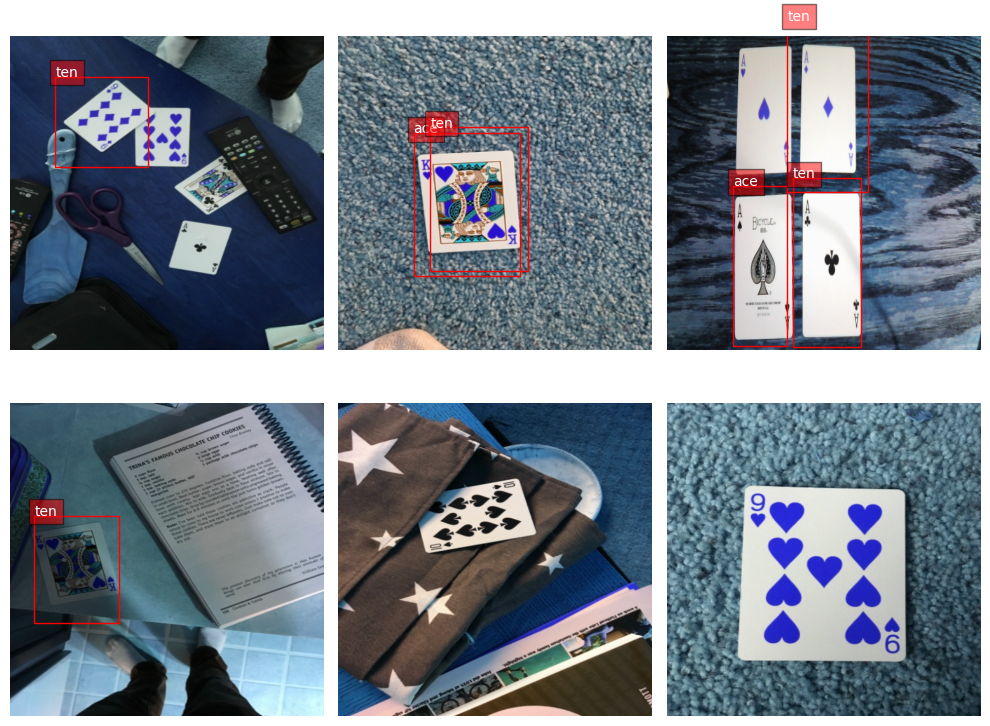

In [20]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

decoded = decode_prediction(preds, upsample=32, threshold=0.2)
visualize(list(imgs), decoded)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 4 but better (1 балл)

## Прикручиваем NMS :^)

Напомним принцип работы алгоритма:
- Сортируем bbox в порядке убывания уверенности
- Считаем Intersection over Union (IoU) для всех bbox 
- Выкидываем все, пересечение с которыми больше порога
- Идем дальше по списку, пока не дойдем до конца

In [21]:
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0

def NMS(bboxes, threshold=0.5):
    if not bboxes:
        return []

    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    final_bboxes = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        final_bboxes.append(chosen_box)

        bboxes = [
            box for box in bboxes
            if iou(chosen_box[:4], box[:4]) < threshold or chosen_box[5] != box[5]
        ]
    
    return final_bboxes

In [22]:
def decode_prediction_nms(pred: torch.Tensor, upsample=32, threshold=0.7, nms_threshold=0.5) -> List[List[List[float]]]:
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    result = []

    x_cell = img_w / w
    y_cell = img_h / h

    for i in range(b):
        boxes = []

        confidence = pred[i, 4, :, :]
        valids = torch.nonzero(confidence >= threshold, as_tuple=True)

        if len(valids[0]) > 0:
            for y_idx, x_idx in zip(*valids):
                cell = pred[i, :, y_idx, x_idx]
                cx_box, cy_box, w_box, h_box = [val.item() for val in cell[:4]]

                if c == 6:
                    class_id = cell[5].item()
                else:
                    class_id = torch.argmax(cell[5:]).item()

                cx = (x_idx + cx_box) * x_cell
                cy = (y_idx + cy_box) * y_cell

                box_width = w_box * img_w
                box_height = h_box * img_h

                xmin = cx - box_width / 2
                ymin = cy - box_height / 2
                xmax = cx + box_width / 2
                ymax = cy + box_height / 2
                conf_score = confidence[y_idx, x_idx].item()

                boxes.append([xmin, ymin, xmax, ymax, conf_score, class_id])
        
        boxes_nms = NMS(boxes, threshold=nms_threshold)
        result.append(boxes_nms)

    return result

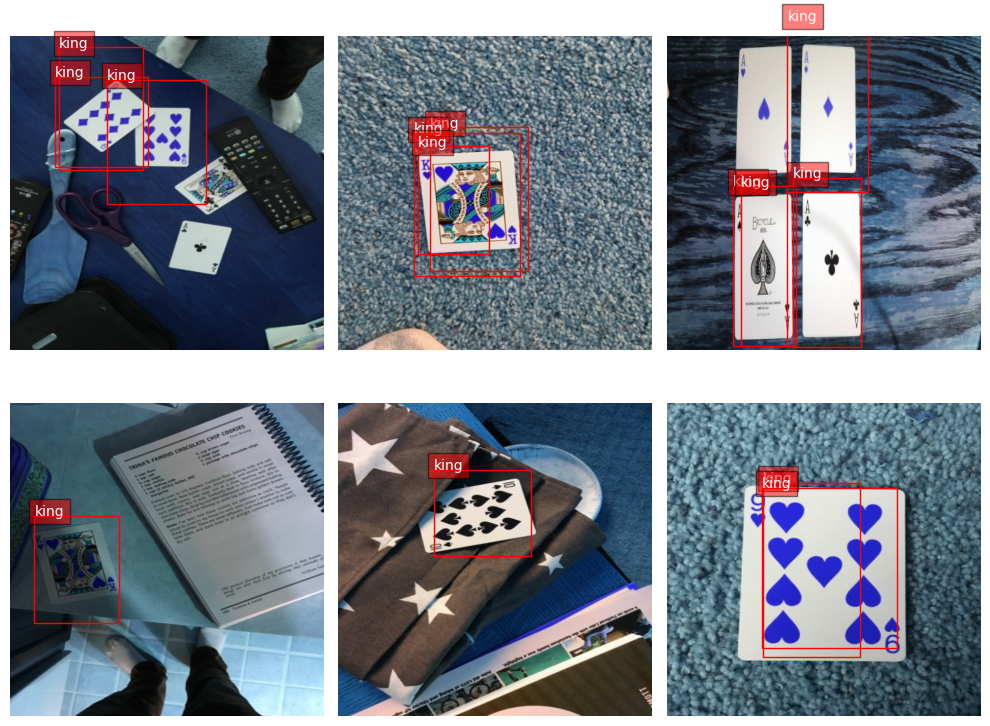

In [23]:
decoded = decode_prediction_nms(preds, upsample=32, threshold=0.1, nms_threshold=0.5)
visualize(list(imgs), decoded)

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [24]:
# !pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [25]:
# Делаем папочки

# !rm -rf train
# !rm -rf valid
# !mkdir -p train/images train/labels valid/images valid/labels

!rmdir /s /q train
!rmdir /s /q valid

!mkdir train
!mkdir train\images
!mkdir train\labels

!mkdir valid
!mkdir valid\images
!mkdir valid\labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [26]:
def annotation2txt(bboxes, w_im, h_im):
    lines = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_id = bbox

        x_center = (xmin + xmax) / 2.0 / w_im
        y_center = (ymin + ymax) / 2.0 / h_im
        width = (xmax - xmin) / w_im
        height = (ymax - ymin) / h_im

        line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        lines.append(line)

    return lines

In [27]:
# Копируем картиночки по папочкам и создаем txt файлики
# Немного переписал

# train
for i in range(len(train_ds)):
    img_path, bboxes = train_ds.__get_raw_item__(i)
    img_path = Path(img_path)

    shutil.copyfile(img_path, Path("train/images") / img_path.name)

    img = cv2.imread(str(img_path))
    h_im, w_im, _ = img.shape

    label_path = Path("train/labels") / (img_path.stem + ".txt")
    with open(label_path, "w", encoding="utf8") as f:
        f.write("\n".join(annotation2txt(bboxes, w_im, h_im)))

# valid
for i in range(len(test_ds)):
    img_path, bboxes = test_ds.__get_raw_item__(i)
    img_path = Path(img_path)

    shutil.copyfile(img_path, Path("valid/images") / img_path.name)

    img = cv2.imread(str(img_path))
    h_im, w_im, _ = img.shape

    label_path = Path("valid/labels") / (img_path.stem + ".txt")
    with open(label_path, "w", encoding="utf8") as f:
        f.write("\n".join(annotation2txt(bboxes, w_im, h_im)))

In [28]:
# Собираем YAML

class_dict = train_ds.class_dict 
nc = len(class_dict)
names = list(class_dict.keys())

yaml_content = f"""train: train/images
val: valid/images

nc: {nc}
names: {names}
"""

with open("data.yaml", "w", encoding="utf8") as f:
    f.write(yaml_content)

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [29]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
res = model.train(data="data.yaml", epochs=50, imgsz=512, device="cuda", project="runs", name="yolo11n", verbose=False)

Ultralytics 8.3.140  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

train: Scanning D:\Study\Mag\DL\HW\HW3\train\labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 765.18it/s]

train: New cache created: D:\Study\Mag\DL\HW\HW3\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.10.0 ms, read: 7.81.7 MB/s, size: 86.6 KB)


val: Scanning D:\Study\Mag\DL\HW\HW3\valid\labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 281.92it/s]

val: New cache created: D:\Study\Mag\DL\HW\HW3\valid\labels.cache


Plotting labels to runs\yolo11n\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\yolo11n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.89G     0.6826      3.388      1.045         25        512: 100%|██████████| 21/21 [00:02<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         37         67     0.0156          1      0.226      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.89G     0.6673      2.828      1.016         11        512: 100%|██████████| 21/21 [00:01<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         37         67     0.0104      0.988      0.359      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.92G     0.6873      2.204      1.038         25        512: 100%|██████████| 21/21 [00:02<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]

                   all         37         67      0.595      0.332      0.475      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.93G     0.6938      1.894      1.033         24        512: 100%|██████████| 21/21 [00:02<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         37         67      0.392      0.616      0.501      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.94G     0.7067      1.709      1.015         36        512: 100%|██████████| 21/21 [00:02<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]

                   all         37         67      0.465      0.839      0.612      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.96G     0.6857      1.603      1.007         31        512: 100%|██████████| 21/21 [00:02<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]


                   all         37         67      0.461      0.876      0.606      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.98G      0.621       1.46     0.9614         25        512: 100%|██████████| 21/21 [00:01<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]

                   all         37         67      0.505      0.833      0.661      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.99G     0.6154       1.38     0.9727         23        512: 100%|██████████| 21/21 [00:02<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


                   all         37         67      0.499      0.812      0.676       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         3G     0.6082      1.323     0.9737         20        512: 100%|██████████| 21/21 [00:01<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]

                   all         37         67      0.645      0.847      0.801      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.02G     0.6006      1.263     0.9499         25        512: 100%|██████████| 21/21 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         37         67      0.654      0.834      0.822      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.04G     0.5841      1.254     0.9661         15        512: 100%|██████████| 21/21 [00:01<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         37         67      0.731      0.841      0.818      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.05G     0.5616      1.152     0.9487         18        512: 100%|██████████| 21/21 [00:01<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]

                   all         37         67       0.84      0.776      0.839      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.06G     0.5714      1.143      0.957         28        512: 100%|██████████| 21/21 [00:01<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         37         67      0.663      0.784      0.764      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.08G     0.5705      1.041     0.9433         31        512: 100%|██████████| 21/21 [00:01<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]

                   all         37         67       0.79      0.877      0.899      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.1G     0.5261      0.983     0.9239         19        512: 100%|██████████| 21/21 [00:01<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         37         67      0.869      0.932      0.944       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.11G     0.5174     0.9586     0.9284         24        512: 100%|██████████| 21/21 [00:01<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         37         67      0.824      0.896      0.955      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.12G     0.5145      0.949     0.9302         17        512: 100%|██████████| 21/21 [00:02<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         37         67        0.7      0.862      0.909      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.14G     0.5259     0.9588     0.9323         24        512: 100%|██████████| 21/21 [00:01<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]

                   all         37         67      0.877      0.916      0.936      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.15G     0.5006     0.8561     0.9211         26        512: 100%|██████████| 21/21 [00:02<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         37         67      0.913      0.804      0.951      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.17G     0.5108     0.8342     0.9277         20        512: 100%|██████████| 21/21 [00:02<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]

                   all         37         67      0.866      0.967      0.968      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.18G     0.4898     0.8191     0.9165         23        512: 100%|██████████| 21/21 [00:01<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         37         67      0.758      0.977      0.953      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.2G     0.4953     0.8213     0.9317         15        512: 100%|██████████| 21/21 [00:02<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]

                   all         37         67      0.833      0.938      0.938       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.21G     0.4801     0.8064     0.9146         26        512: 100%|██████████| 21/21 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]

                   all         37         67      0.853        0.9      0.934      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.23G     0.4884     0.8193     0.9238         19        512: 100%|██████████| 21/21 [00:01<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]

                   all         37         67       0.83      0.963      0.973      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.24G     0.4716      0.774     0.9089         32        512: 100%|██████████| 21/21 [00:01<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]

                   all         37         67      0.895      0.853      0.931      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.26G     0.4432     0.7018     0.8966         26        512: 100%|██████████| 21/21 [00:01<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

                   all         37         67      0.772      0.922      0.946      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.28G     0.4695     0.7367     0.9149         20        512: 100%|██████████| 21/21 [00:02<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]

                   all         37         67      0.889      0.926      0.961       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.29G     0.4737     0.7354     0.9111         33        512: 100%|██████████| 21/21 [00:02<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         37         67      0.877       0.93      0.924      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.29G     0.4543     0.7239     0.9246         23        512: 100%|██████████| 21/21 [00:01<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


                   all         37         67      0.884      0.905       0.95        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.32G     0.4666     0.6777     0.9118         24        512: 100%|██████████| 21/21 [00:01<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]

                   all         37         67      0.892      0.934      0.968      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.33G     0.4652     0.6629      0.916         33        512: 100%|██████████| 21/21 [00:01<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]

                   all         37         67      0.846       0.94      0.962      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.35G     0.4348     0.6664     0.9013         17        512: 100%|██████████| 21/21 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         37         67      0.926      0.896      0.954      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.35G      0.446     0.6354     0.9046         20        512: 100%|██████████| 21/21 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         37         67      0.902      0.864      0.937      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.38G     0.4556     0.6815     0.9023         32        512: 100%|██████████| 21/21 [00:02<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         37         67      0.891      0.829      0.942      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.39G     0.4213     0.6053     0.8895         26        512: 100%|██████████| 21/21 [00:01<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]

                   all         37         67      0.912      0.958      0.965      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.41G     0.4284      0.646     0.8964         29        512: 100%|██████████| 21/21 [00:01<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


                   all         37         67      0.947      0.924      0.975      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.41G     0.3916     0.5741     0.8773         17        512: 100%|██████████| 21/21 [00:01<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]

                   all         37         67      0.879       0.96      0.972      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.44G     0.4143     0.5905     0.8945         15        512: 100%|██████████| 21/21 [00:01<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         37         67      0.919      0.986      0.975      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.45G     0.4092     0.5803     0.8825         17        512: 100%|██████████| 21/21 [00:01<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]

                   all         37         67      0.955      0.954      0.975      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.46G     0.4153      0.587     0.8964         22        512: 100%|██████████| 21/21 [00:01<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]

                   all         37         67      0.927      0.976      0.982      0.925


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.47G     0.3292     0.5509     0.8292         10        512: 100%|██████████| 21/21 [00:02<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]

                   all         37         67       0.91      0.945      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.49G     0.3349     0.5552     0.8125         12        512: 100%|██████████| 21/21 [00:01<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


                   all         37         67      0.906      0.962      0.976      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.51G     0.3153     0.5173     0.8133         12        512: 100%|██████████| 21/21 [00:01<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         37         67      0.948      0.963      0.982      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.53G     0.3144     0.5035     0.7995          8        512: 100%|██████████| 21/21 [00:01<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]

                   all         37         67      0.951      0.977      0.983      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.54G     0.3028     0.4886     0.8108          6        512: 100%|██████████| 21/21 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]

                   all         37         67      0.947      0.973      0.984      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.55G     0.3015     0.4906     0.8143         16        512: 100%|██████████| 21/21 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.92it/s]

                   all         37         67      0.937      0.958       0.97      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.57G     0.3038     0.4861     0.7974          7        512: 100%|██████████| 21/21 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]

                   all         37         67      0.948      0.991      0.984      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.58G     0.3056     0.4788     0.8056         10        512: 100%|██████████| 21/21 [00:01<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

                   all         37         67      0.941      0.968      0.982      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.59G     0.2952      0.467     0.8034         10        512: 100%|██████████| 21/21 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]

                   all         37         67      0.916      0.985      0.981      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.61G     0.2931     0.4554     0.8088         12        512: 100%|██████████| 21/21 [00:01<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]

                   all         37         67      0.945       0.97      0.981      0.944



50 epochs completed in 0.039 hours.
Optimizer stripped from runs\yolo11n\weights\last.pt, 5.4MB
Optimizer stripped from runs\yolo11n\weights\best.pt, 5.4MB

Validating runs\yolo11n\weights\best.pt...
Ultralytics 8.3.140  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


                   all         37         67      0.945       0.97      0.981      0.944
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\yolo11n


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.


0: 512x512 4 aces, 8.9ms
1: 512x512 1 king, 8.9ms
2: 512x512 1 ten, 8.9ms
3: 512x512 4 nines, 8.9ms
4: 512x512 1 ace, 8.9ms
5: 512x512 1 ten, 8.9ms
6: 512x512 1 ace, 8.9ms
7: 512x512 1 queen, 8.9ms
Speed: 1.4ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)


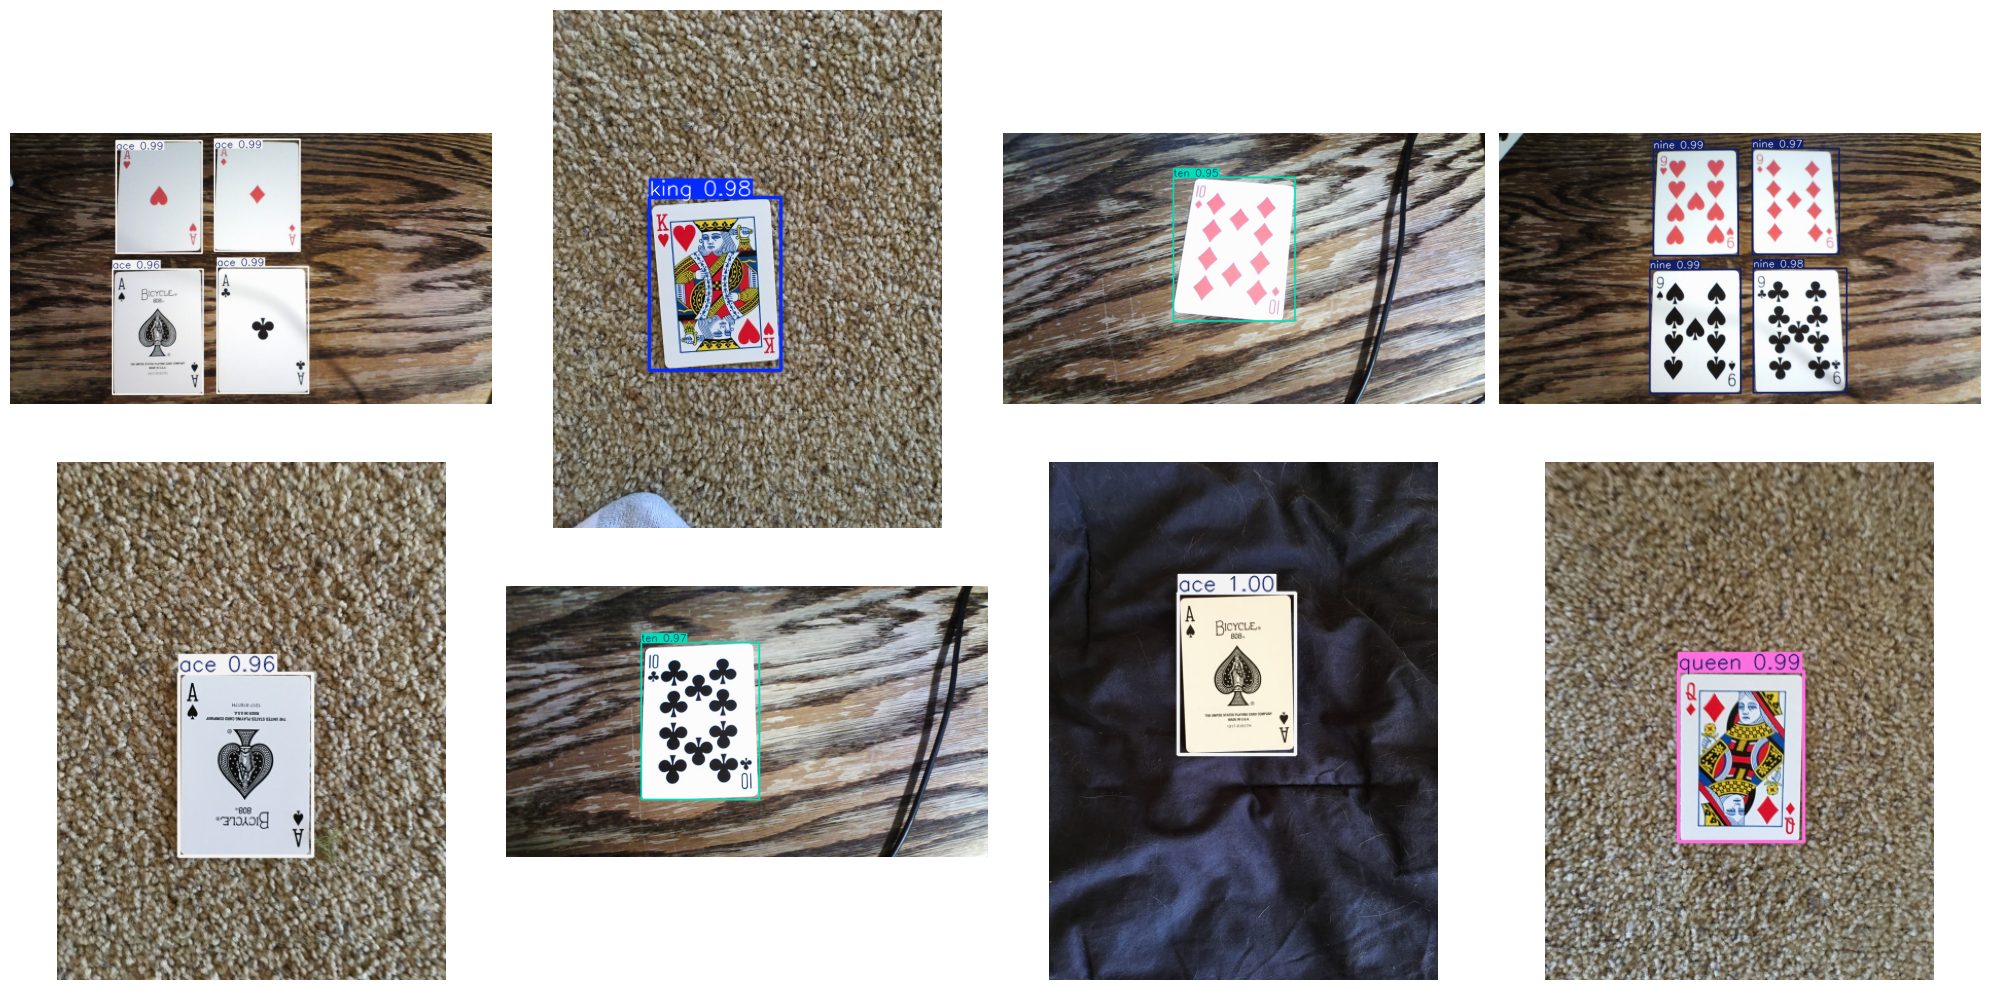

In [30]:
import random


model = YOLO("runs/yolo11n/weights/best.pt")

val_imgs = list(Path("valid/images").glob("*.jpg"))[:8]
sample_imgs = random.sample(val_imgs, k=8)
results = model(sample_imgs, save=False)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (ax, r) in enumerate(zip(axes, results)):
    img = r.plot()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img_rgb)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Бонус (1 балл)

Реализуйте подсчет mAP для самописной модели. Если найдете готовый код на гитхабах -- используйте с указанием ссылок :)

Сравните свою модель с YOLO11. Что получается?

In [ ]:
# лень...